In [1]:
import numpy as np
import pandas as pd
SEED = 42
np.random.seed(SEED)

# Read in and process key data:

In [2]:
#Read in the Swissprot human proteome :
swissprot = pd.read_excel('Data/Swissprot/human_swissprot.xlsx')
swissprot = swissprot[swissprot['Gene'].notna()]

In [3]:
#Read in condensate mass spec data (Freibaum et al.):
proteins_NPM1 = pd.read_excel('Data/Condensate_mass-spec/NPM1_data/media-4.xlsx')
#proteins_NPM1 = pd.read_excel('Data/Condensate_mass-spec/jcb_202009079_tables1.xlsx')

#Remove the cases where the uniprot ID does not correspond to the human swissprot dataset
proteins_NPM1 = proteins_NPM1[proteins_NPM1['Gene_NPM1'].isin(swissprot['Gene'])]
print('Number of proteins partitioning into NPM1 granules (pc > 2) : ' + str(proteins_NPM1.shape[0]))
swissprot['condensate'] = swissprot['Gene'].isin(proteins_NPM1['Gene_NPM1'])
#Map counts:
condensate_count_dict = dict(zip(proteins_NPM1['Gene_NPM1'], proteins_NPM1['Spectra Count Granules NPM1']))
control_count_dict = dict(zip(proteins_NPM1['Gene_NPM1'], proteins_NPM1['Spectra Count Control NPM1']))
swissprot['Granules_count']  = swissprot['Gene'].map(condensate_count_dict)
swissprot['Control_count']  = swissprot['Gene'].map(control_count_dict)

Number of proteins partitioning into NPM1 granules (pc > 2) : 1063


In [4]:
#Get expression levels of the proteins in U2OS cell lines
proteome = pd.read_excel('Data/Proteome/msb201182-s2.xls', header = [0])
expression_dict = dict(zip(proteome['SP_id'], proteome['copies per cell']))
swissprot['expression'] = swissprot['Entry'].map(expression_dict)
df_analyse = swissprot[swissprot['expression'].notna()]

#Change expression values of <500 to a random value between 0 and 500:
df_analyse['expression'] = np.where(df_analyse['expression'] == '<5e2', 250, df_analyse['expression'])
df_analyse['expression'] = df_analyse['expression']
random_values = np.random.randint(500, size = df_analyse[df_analyse['expression'] == 250].shape[0])
df_temp = df_analyse[(df_analyse['expression'] < 500)]
df_temp = df_temp.drop(columns = 'expression')
df_temp['expression'] = random_values
df_remaining = df_analyse[df_analyse['expression'] >= 500]
df_analyse = pd.concat([df_temp, df_remaining], axis = 0)
#replace zeros with 1 to enable taking logarithms
df_analyse['expression'] = df_analyse['expression'].replace(0, 1)
df_analyse['log_expression'] = [np.log10(x) for x in df_analyse['expression']]
df_analyse = df_analyse[df_analyse['Gene'].notna()]
df_analyse['Enrichment'] = df_analyse['Granules_count'] /df_analyse['Control_count']

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/1480954695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyse['expression'] = np.where(df_analyse['expression'] == '<5e2', 250, df_analyse['expression'])
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/1480954695.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyse['expression'] = df_analyse['expression']
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/1480954695.py:17: FutureWarning: Dow

In [5]:
#Remove mictochonrdial proteins as this is likely an artefact of the experimental protocol
#Read in GO-terms
GOs = pd.read_csv('Data/Swissprot/GOs.csv')
#Extract those that include mitochondrion related term
excl1 = GOs[GOs['Gene ontology (biological process)'].notna()]
excl1 = list(excl1['Entry'][excl1['Gene ontology (biological process)'].str.contains('itochondri')])
excl2 = GOs[GOs['Gene ontology (cellular component)'].notna()]
excl2 = list(excl2['Entry'][excl2['Gene ontology (cellular component)'].str.contains('itochondri')])
excl3 = GOs[GOs['Gene ontology (molecular function)'].notna()]
excl3 = list(excl3['Entry'][excl3['Gene ontology (molecular function)'].str.contains('itochondri')])
micochondrion_exclude = list(set(list(excl1) + list(excl2) + list(excl3) ))
df_analyse = df_analyse[df_analyse['Entry'].isin(micochondrion_exclude) == False]
#Finally, save all data to disc:
df_analyse.to_csv('Output/data_all.csv')

# Characterise NPM1 condensate data

In [6]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

#Plot settings
sns.set(font_scale=1.5) 
sns.set_style('white'); sns.set_style('ticks')

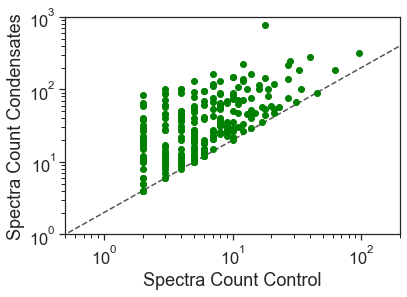

In [7]:
plt.plot(df_analyse['Control_count'], df_analyse['Granules_count'], 'o', color = 'green')
plt.xlabel('Spectra Count Control')
plt.ylabel('Spectra Count Condensates')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.5, 200])
plt.ylim([1, 1000])
lims = [0.1, 200]
plt.plot(lims, 2*np.array(lims), 'k--', alpha = 0.75, zorder = 0)
plt.savefig('Plots/enrichment_NPM1.pdf')
plt.show()

condensate
COND-    5292
COND+     894
Name: count, dtype: int64


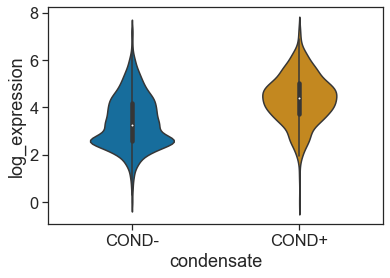

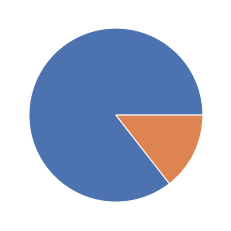

In [8]:
#Check expression levels
df_analyse['condensate'] = np.where(df_analyse['condensate'] == True, 'COND+', 'COND-')
print(df_analyse['condensate'].value_counts())
sns.violinplot(y='log_expression', x='condensate', data = df_analyse, width=0.5, palette="colorblind")
plt.show()

plt.pie(df_analyse['condensate'].value_counts())
plt.savefig('Plots/pie_chart_NPM1.pdf')

condensate
COND-    2237
COND+     721
Name: count, dtype: int64


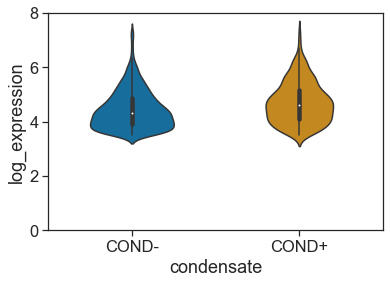

In [9]:
#Focus on high expression data only to understand features

df_HE = df_analyse[df_analyse['log_expression'] > 3.5]
print(df_HE['condensate'].value_counts())
sns.violinplot(y='log_expression', x='condensate', data = df_HE, width=0.5, palette="colorblind")
plt.ylim([0, 8])
df_HE.to_csv('Output/data_HE.csv')
plt.show()

# Compare NPM1 condensate features and RNA-interactions

In [10]:
#Read in the previously saved file with condensate annotations:
df_HE = pd.read_csv('Output/data_HE.csv')
#make a dictionary between the protein ID and the condensate partioning
cond_dict = dict(zip(df_HE['Gene'], df_HE['condensate']))
enr_dict = dict(zip(df_HE['Gene'], df_HE['Enrichment']))

#Read in pre-calculated features for all proteins:
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
#Add a column describing the category
features['category'] = features['Gene'].map(cond_dict)
#Read in a dataset of proteins that can undergo phase separation in isolation:
LLPS = pd.read_excel('Data/LLPS_data/phasepdbv2_1_llps.xlsx')
LLPS = LLPS[LLPS['class'] == 'PS-self']
#Read in a set of sequene diverse set of fully structured proteins(refer to Saar et al PNAS 2021 for full description)
PDB_star = pd.read_csv('Data/LLPS_data/pdb30.csv', sep = '\t')

features['category'] = np.where(features['Entry'].isin(LLPS['uniprot_entry']), 'LLPS-prone', features['category'])
features['category'] = np.where(features['Entry'].isin(PDB_star['UniProt']), 'folded', features['category'])
features['category'] = np.where(features['category'] == 'COND+', 'COND+', features['category'])
features['category'] = np.where(features['category'] == 'COND-', 'COND-', features['category'])

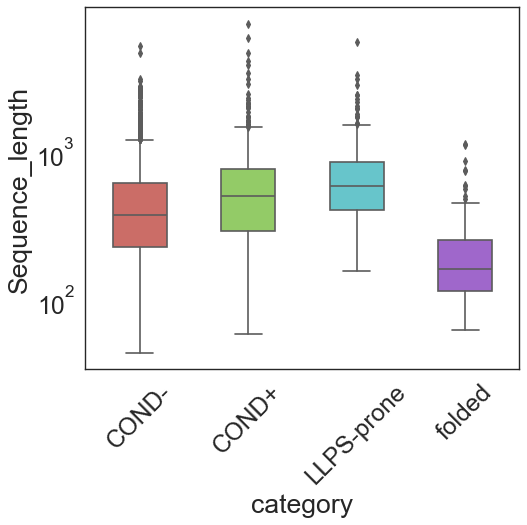

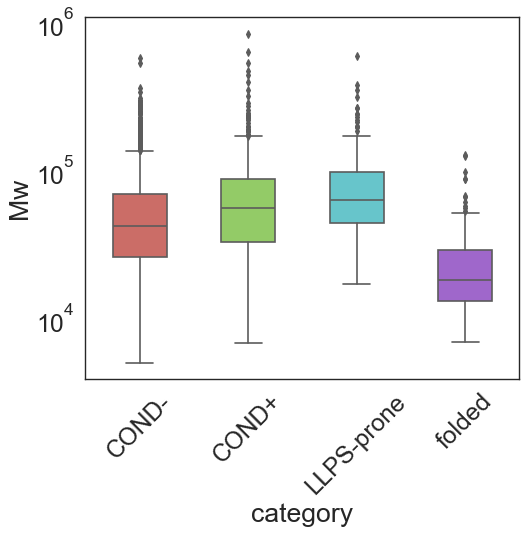

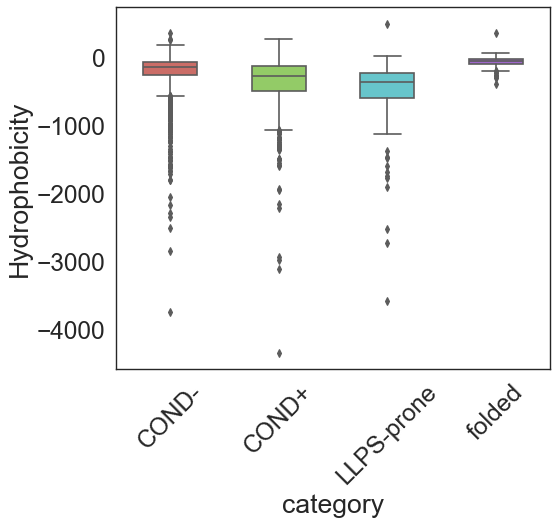

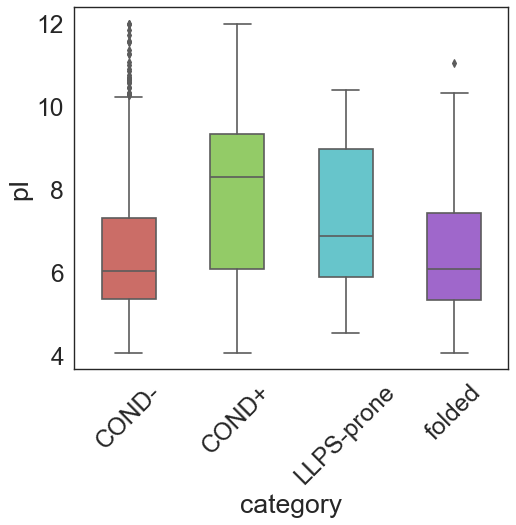

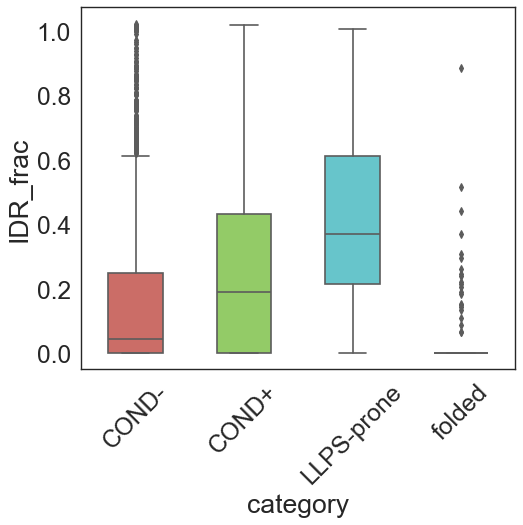

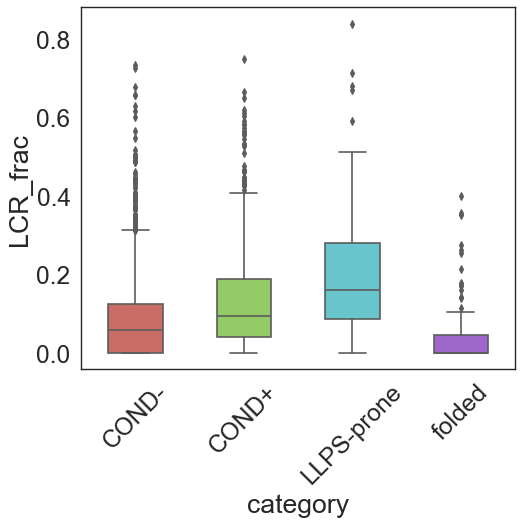

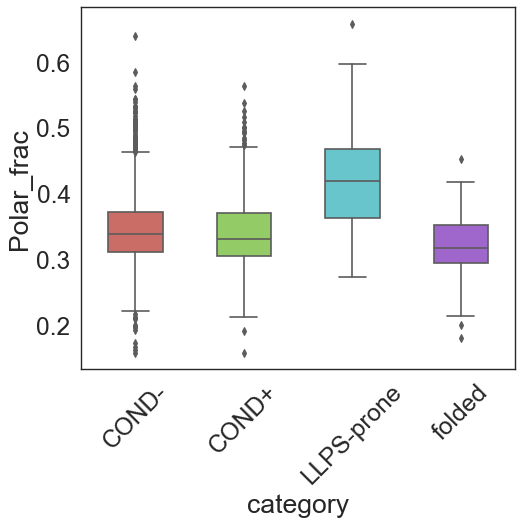

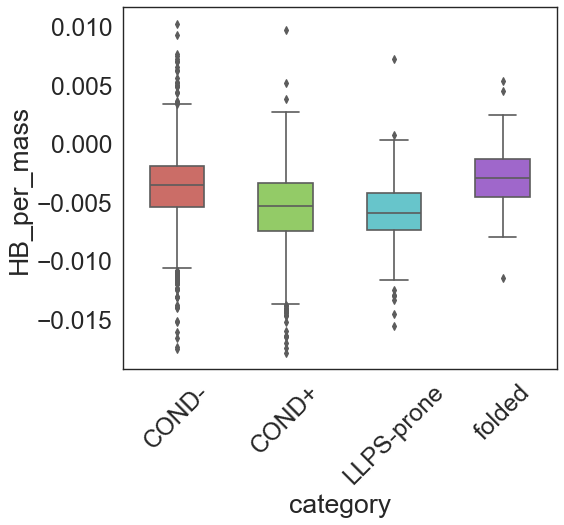

In [11]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
features['Mw'] = [ProteinAnalysis(x).molecular_weight() for x in features['sequence_final']]
features['HB_per_mass'] = features['Hydrophobicity'] / features['Mw']

#Make plots of how the features var
sns.set(style='white', font_scale=2)

sns.color_palette("tab10")
features_plot = ['Sequence_length', 'Mw']
for k in range(len(features_plot)):
    figure(figsize=(7, 6), dpi=80)
    sns.boxplot(y=features_plot[k], x='category', data = features, width=0.5, palette="hls")
    plt.xticks(rotation = 45);  plt.yscale('log')
    plt.savefig('Plots/' + str(features_plot[k]) + '_NPM1.pdf')
    plt.show()
    
features_plot = ['Hydrophobicity', 'pI', 'IDR_frac', 'LCR_frac', 'Polar_frac','HB_per_mass']
for k in range(len(features_plot)):
    figure(figsize=(7, 6), dpi=80)
    sns.boxplot(y=features_plot[k], x='category', data = features, width=0.5, palette="hls")
    plt.xticks(rotation = 45) 
    plt.savefig('Plots/' + str(features_plot[k]) + '_NPM1.pdf')
    plt.show()

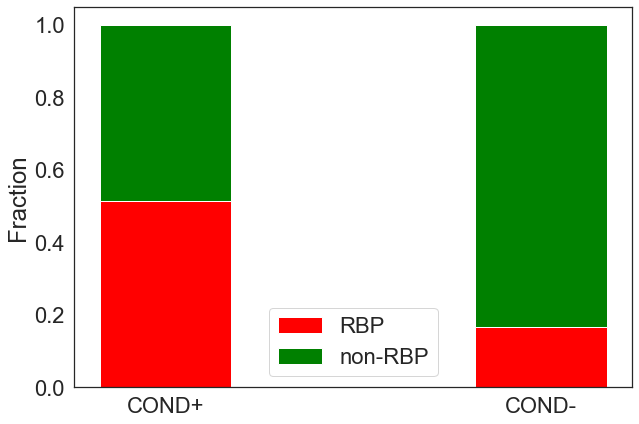

DeePhase_cat
non-LLPS+    0.767908
LLPS+        0.232092
Name: count, dtype: float64
DeePhase_cat
non-LLPS+    0.809668
LLPS+        0.190332
Name: count, dtype: float64
DeePhase_cat
non-LLPS+    0.781513
LLPS+        0.218487
Name: count, dtype: float64
DeePhase_cat
non-LLPS+    0.892737
LLPS+        0.107263
Name: count, dtype: float64


In [12]:
COND_plus = features['Entry'][features['category'] == 'COND+']
COND_minus = features['Entry'][features['category'] == 'COND-']

#Use the DeePhase score to add annocations to which proteins in each category have a high propensity to undergo phase separation:
features['DeePhase_cat'] = np.where(features['SC_score'] > 0.8, 'LLPS+', 'non-LLPS+')

#Find how many proteins in each category are / are not RNA-binding
COND_plus_RBP = features[(features['RNA_binding'] == 1) & features['Entry'].isin(COND_plus)]
COND_plus_non_RBP = features[(features['RNA_binding'] == 0) & features['Entry'].isin(COND_plus)]
sum1 = len(COND_plus_RBP) + len(COND_plus_non_RBP)
COND_minus_RBP = features[(features['RNA_binding'] == 1) & features['Entry'].isin(COND_minus)]
COND_minus_non_RBP = features[(features['RNA_binding'] == 0) & features['Entry'].isin(COND_minus)]
sum2 = len(COND_minus_RBP) + len(COND_minus_non_RBP)

#Make plot
N = 2; width = 0.35 
cat1 = (len(COND_plus_RBP) / sum1, len(COND_minus_RBP) / sum2 )
cat2 = (len(COND_plus_non_RBP) / sum1, len(COND_minus_non_RBP) / sum2)
ind = np.arange(N)  

fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, cat1, width, color = 'red')
p2 = plt.bar(ind, cat2, width, bottom = cat1, color = 'green')
plt.ylabel('Fraction')
plt.xticks(ind, ('COND+', 'COND-'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('RBP', 'non-RBP'))
plt.show()

#Finally, also print out the fraction of condensation-prone proteins in each of the categories:
print(COND_plus_RBP['DeePhase_cat'].value_counts() / len(COND_plus_RBP))
print(COND_plus_non_RBP['DeePhase_cat'].value_counts() / len(COND_plus_non_RBP))
print(COND_minus_RBP['DeePhase_cat'].value_counts() / len(COND_minus_RBP))
print(COND_minus_non_RBP['DeePhase_cat'].value_counts() / len(COND_minus_non_RBP))

In [13]:
#Evaluate, how the features between COND+ and COND- datasets differ between RNA-binding and non-RNA-binding proteins

In [14]:
from scipy.stats import mannwhitneyu
def cliffs_delta(x, y):
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    delta = ((2. * u) / (n1 * n2)) - 1
    return delta

In [15]:
parameters = ['Sequence_length', 'Hydrophobicity', 'Shannon_entropy', 'IDR_frac',
 'pI', 'Polar_frac', 'Arom_frac', 'Cation_frac', 'Anion_frac', 'HB_per_mass']
df = pd.Series(parameters)

RNA_binding_df = features[features['RNA_binding'] == 1]
p_values = []; cliff_deltas = []
for k in range(0, len(parameters)):
    a = RNA_binding_df[parameters[k]][RNA_binding_df['category'] == 'COND+']
    b = RNA_binding_df[parameters[k]][RNA_binding_df['category'] == 'COND-']
    p_value_here = mannwhitneyu(a, b)[1]
    p_values.append(-np.log10(p_value_here))
    delta_here = cliffs_delta(a, b)
    cliff_deltas.append(delta_here)
results_df1 = pd.DataFrame({'features': parameters, 'Cliff delta RNA': cliff_deltas, 'p value RNA': p_values})

RNA_not_binding_df = features[features['RNA_binding'] == 0]
p_values = []; cliff_deltas = []
for k in range(0, len(parameters)):
    a = RNA_not_binding_df[parameters[k]][RNA_not_binding_df['category'] == 'COND+']
    b = RNA_not_binding_df[parameters[k]][RNA_not_binding_df['category'] == 'COND-']
    p_value_here = mannwhitneyu(a, b)[1]
    p_values.append(-np.log10(p_value_here))
    delta_here = cliffs_delta(a, b)
    cliff_deltas.append(delta_here)
results_df2 = pd.DataFrame({'features': parameters, 'Cliff delta no RNA': cliff_deltas, 'p value no RNA': p_values})

#Merge
results_df = results_df1.merge(results_df2, left_on = 'features', right_on = 'features')

In [16]:
results_df['effect_max'] = results_df[['Cliff delta RNA', 'Cliff delta RNA']].max(axis = 1)
results_df = results_df.sort_values(by = 'effect_max')

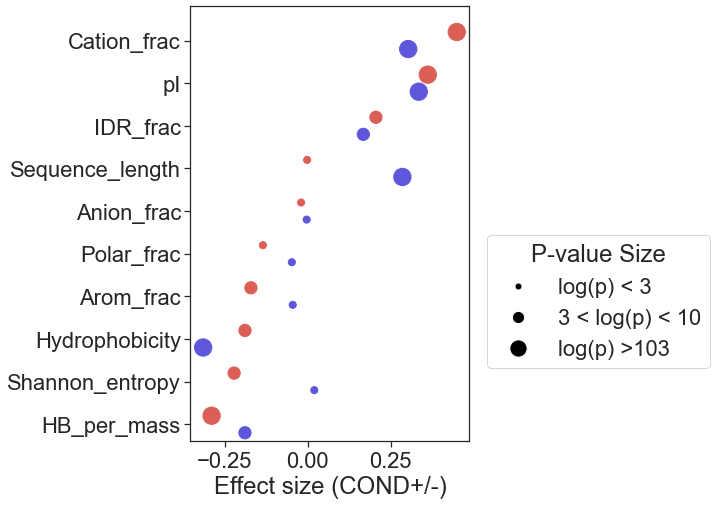

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 8))
cbar = sns.color_palette("hls")
ind = np.arange(len(results_df))

# Define marker sizes
small_size = 50  # Smallest marker size
medium_size = 150  # Medium marker size
large_size = 300  # Biggest marker size

# Function to categorize sizes based on p-value
def categorize_sizes(p_values):
    sizes = []
    for p in p_values:
        if p > 10:
            sizes.append(large_size)
        elif p > 3:
            sizes.append(medium_size)
        else:
            sizes.append(small_size)
    return sizes

# Apply categorization to p-values
size_scale_rna = categorize_sizes(results_df['p value RNA'])
size_scale_no_rna = categorize_sizes(results_df['p value no RNA'])

plt.scatter(results_df['Cliff delta RNA'], ind + 0.4, s=size_scale_rna, label='RNA-binding', color=cbar[0])
plt.scatter(results_df['Cliff delta no RNA'], ind, s=size_scale_no_rna, label='RNA non-binding', color=cbar[4])

plt.xlabel('Effect size (COND+/-)')
ax.set(yticks=ind + 0.2, yticklabels=results_df['features'], ylim=[2 * 0.4 - 1, len(results_df)])

ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=np.sqrt(small_size), label='log(p) < 3'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=np.sqrt(medium_size), label='3 < log(p) < 10'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=np.sqrt(large_size), label='log(p) >103')]

ax.legend(handles=legend_elements, loc='upper right', title="P-value Size", bbox_to_anchor=(1.9, 0.5))
plt.savefig('Plots/RNA_binding_vs_not_features.pdf', bbox_inches='tight', dpi=300)


# Characterise G3BP1 reconstituted condensates

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

In [19]:
#Read in condensate mass spec data (Freibaum et al.):
proteins_G3BP1 = pd.read_excel('Data/Condensate_mass-spec/G3BP1_data/jcb_202009079_tables1.xlsx')
#Remove the cases where the uniprot ID does not correspond to the human swissprot dataset
proteins_G3BP1 = proteins_G3BP1[proteins_G3BP1['Gene_G3BP1'].isin(swissprot['Gene'])]
print('Number of proteins partitioning into G3BP1 granules (pc > 2) : ' + str(proteins_G3BP1.shape[0]))
swissprot['condensate'] = swissprot['Gene'].isin(proteins_G3BP1['Gene_G3BP1'])

#Map counts:
condensate_count_dict = dict(zip(proteins_G3BP1['Gene_G3BP1'], proteins_G3BP1['Spectra Count Granules G3BP1']))
control_count_dict = dict(zip(proteins_G3BP1['Gene_G3BP1'], proteins_G3BP1['Spectra Count Control G3BP1']))
swissprot['G3BP1_Granules_count']  = swissprot['Gene'].map(condensate_count_dict)
swissprot['G3BP1_Control_count']  = swissprot['Gene'].map(control_count_dict)

Number of proteins partitioning into G3BP1 granules (pc > 2) : 384


In [20]:
#Get expression levels of the proteins in U2OS cell lines
proteome = pd.read_excel('Data/Proteome/msb201182-s2.xls', header = [0])
expression_dict = dict(zip(proteome['SP_id'], proteome['copies per cell']))
swissprot['expression'] = swissprot['Entry'].map(expression_dict)
df_analyse = swissprot[swissprot['expression'].notna()]

#Change expression values of <500 to a random value between 0 and 500:
df_analyse['expression'] = np.where(df_analyse['expression'] == '<5e2', 250, df_analyse['expression'])
df_analyse['expression'] = df_analyse['expression']
random_values = np.random.randint(500, size = df_analyse[df_analyse['expression'] == 250].shape[0])
df_temp = df_analyse[(df_analyse['expression'] < 500)]
df_temp = df_temp.drop(columns = 'expression')
df_temp['expression'] = random_values
df_remaining = df_analyse[df_analyse['expression'] >= 500]
df_analyse = pd.concat([df_temp, df_remaining], axis = 0)
#replace zeros with 1 to enable taking logarithms
df_analyse['expression'] = df_analyse['expression'].replace(0, 1)
df_analyse['log_expression'] = [np.log10(x) for x in df_analyse['expression']]
df_analyse = df_analyse[df_analyse['Gene'].notna()]
df_analyse['G3BP1_Enrichment'] = df_analyse['G3BP1_Granules_count'] /df_analyse['G3BP1_Control_count']

/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/3483182669.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyse['expression'] = np.where(df_analyse['expression'] == '<5e2', 250, df_analyse['expression'])
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/3483182669.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyse['expression'] = df_analyse['expression']
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_44661/3483182669.py:17: FutureWarning: Dow

In [21]:
#Remove mictochonrdial proteins as this is likely an artefact of the experimental protocol
#Read in GO-terms
GOs = pd.read_csv('Data/Swissprot/GOs.csv')
#Extract those that include mitochondrion related term
excl1 = GOs[GOs['Gene ontology (biological process)'].notna()]
excl1 = list(excl1['Entry'][excl1['Gene ontology (biological process)'].str.contains('itochondri')])
excl2 = GOs[GOs['Gene ontology (cellular component)'].notna()]
excl2 = list(excl2['Entry'][excl2['Gene ontology (cellular component)'].str.contains('itochondri')])
excl3 = GOs[GOs['Gene ontology (molecular function)'].notna()]
excl3 = list(excl3['Entry'][excl3['Gene ontology (molecular function)'].str.contains('itochondri')])
micochondrion_exclude = list(set(list(excl1) + list(excl2) + list(excl3) ))
df_analyse = df_analyse[df_analyse['Entry'].isin(micochondrion_exclude) == False]
#Finally, save all data to disc:
df_analyse.to_csv('Output/data_all_G3BP1.csv')
df_analyse['G3BP1_Enrichment'].notna().sum()

311

In [22]:
df_analyse = pd.read_csv('Output/data_all_G3BP1.csv')
#Plot settings
sns.set(font_scale=1.5) 
sns.set_style("white")
sns.set_style("ticks")

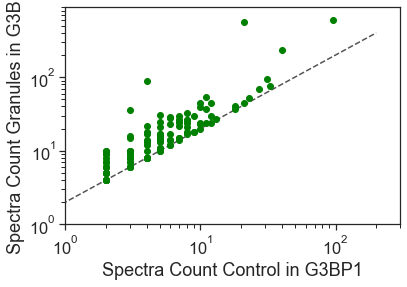

In [23]:
plt.plot(df_analyse['G3BP1_Control_count'], df_analyse['G3BP1_Granules_count'], 'o', color = 'green')
plt.xlabel('Spectra Count Control in G3BP1')
plt.ylabel('Spectra Count Granules in G3BP1')
plt.xscale('log')
plt.yscale('log')
lims = [0.1, 200]
plt.ylim([1, 900]); plt.xlim([1, 300])
plt.plot(lims, 2*np.array(lims), 'k--', alpha = 0.75, zorder = 0)
plt.savefig('Plots/enrichment_G3BP1.pdf', dpi = 300)
plt.show()

condensate
False    2669
True      289
Name: count, dtype: int64


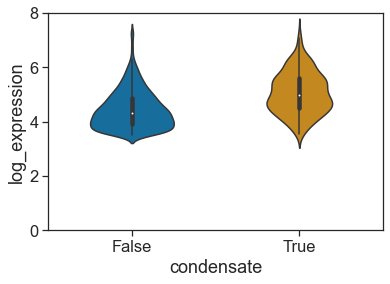

In [24]:
#Focus on high expression data only to understand features
df_HE = df_analyse[df_analyse['log_expression'] > 3.5]
print(df_HE['condensate'].value_counts())
sns.violinplot(y='log_expression', x='condensate', data = df_HE, width=0.5, palette="colorblind")
plt.ylim([0, 8])
plt.show()
df_HE.to_csv('Output/data_HE_G3BP1.csv')

# Compare features - reconstituted G3BP1 condensates

In [25]:
#Read in the previously saved file with condensate annotations:
df_HE = pd.read_csv('Output/data_HE_G3BP1.csv')
#make a dictionary between the protein ID and the condensate partioning
cond_dict = dict(zip(df_HE['Gene'], df_HE['condensate']))
enr_dict = dict(zip(df_HE['Gene'], df_HE['G3BP1_Enrichment']))

#Read in pre-calculated features for all proteins:
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
#Add a column describing the category
features['category'] = features['Gene'].map(cond_dict)
#Read in a dataset of proteins that can undergo phase separation in isolation:
LLPS = pd.read_excel('Data/LLPS_data/phasepdbv2_1_llps.xlsx')
LLPS = LLPS[LLPS['class'] == 'PS-self']
#Read in a set of sequene diverse set of fully structured proteins(refer to Saar et al PNAS 2021 for full description)
PDB_star = pd.read_csv('Data/LLPS_data/pdb30.csv', sep = '\t')

features['category'] = np.where(features['Entry'].isin(LLPS['uniprot_entry']), 'LLPS-prone', features['category'])
features['category'] = np.where(features['Entry'].isin(PDB_star['UniProt']), 'folded', features['category'])
features['category'] = np.where(features['category'] == 'COND+', 'COND+', features['category'])
features['category'] = np.where(features['category'] == 'COND-', 'COND-', features['category'])

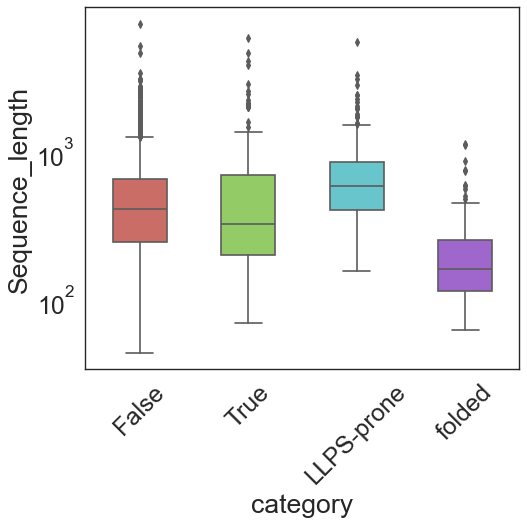

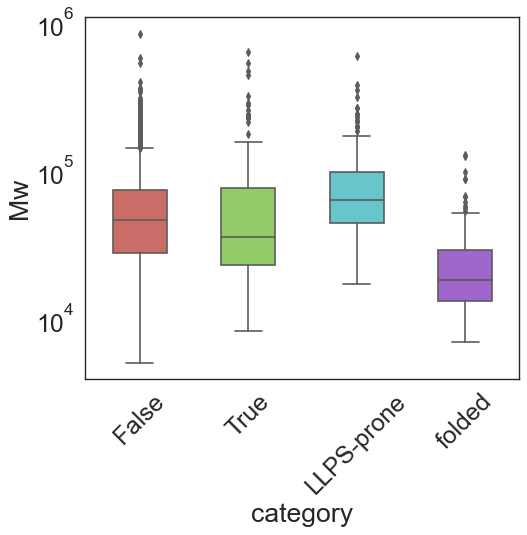

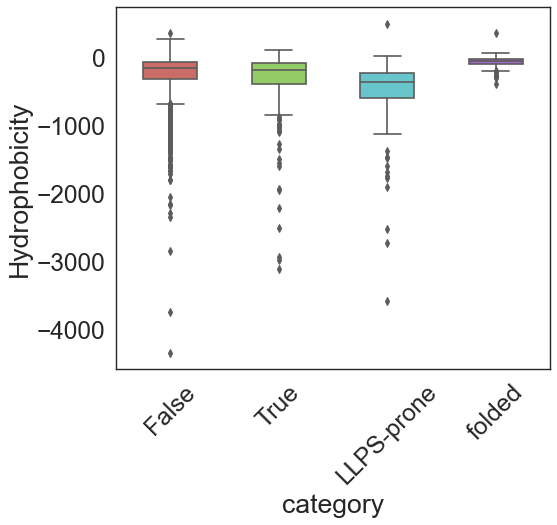

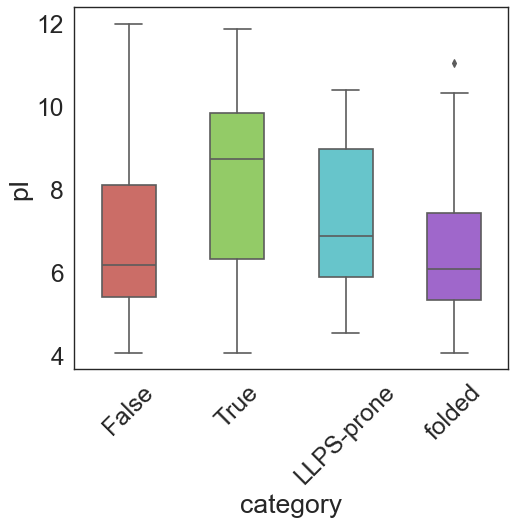

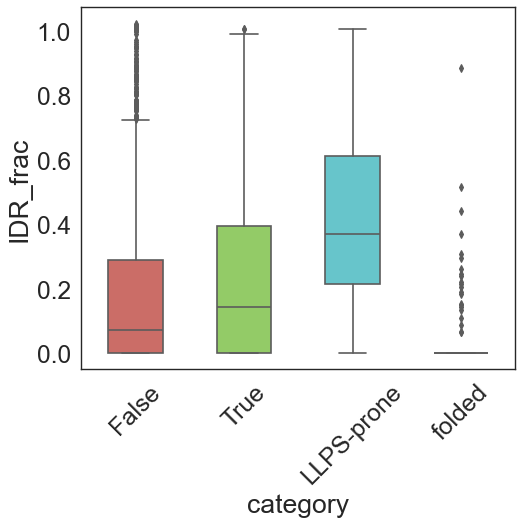

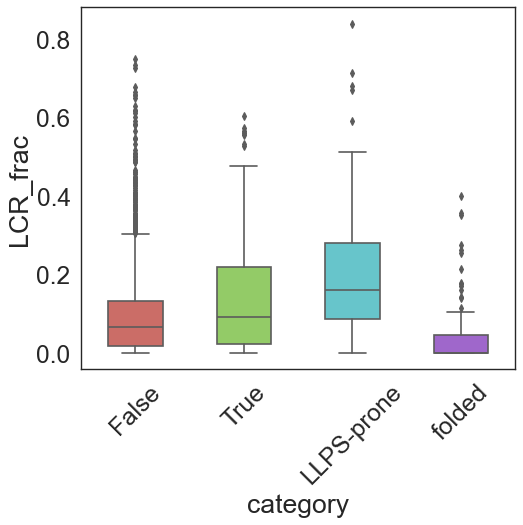

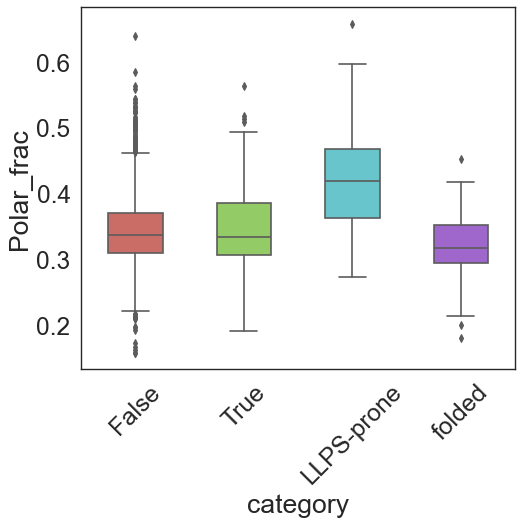

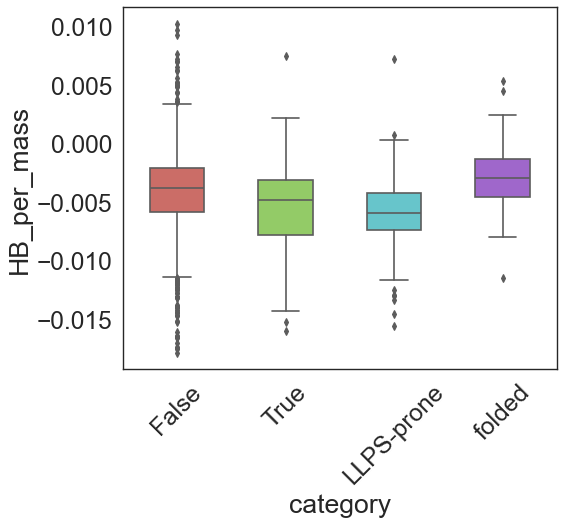

In [26]:
features['Mw'] = [ProteinAnalysis(x).molecular_weight() for x in features['sequence_final']]
features['HB_per_mass'] = features['Hydrophobicity'] / features['Mw']

sns.set(style='white', font_scale=2)
sns.color_palette("tab10")
features_plot = ['Sequence_length', 'Mw']
for k in range(len(features_plot)):
    figure(figsize=(7, 6), dpi=80)
    sns.boxplot(y=features_plot[k], x='category', data = features, width=0.5, palette="hls")
    plt.xticks(rotation = 45);  plt.yscale('log')
    plt.savefig('Plots/' + str(features_plot[k]) + '_G3BP1.pdf')
    plt.show()
    
features_plot = ['Hydrophobicity', 'pI', 'IDR_frac', 'LCR_frac', 'Polar_frac','HB_per_mass']
for k in range(len(features_plot)):
    figure(figsize=(7, 6), dpi=80)
    sns.boxplot(y=features_plot[k], x='category', data = features, width=0.5, palette="hls")
    plt.xticks(rotation = 45) 
    plt.savefig('Plots/' + str(features_plot[k]) + '_G3BP1.pdf')
    plt.show()